## **Smart Waste Classification Using Machine Learning**
**Student:** Alia Bazeel  
**Dataset:** Trashify Image Dataset (Kaggle)  
**Objective:** Develop a machine learning model capable of classifying waste into three categories: Metal, Paper, and Plastic.  

Proper waste segregation is a critical step in promoting sustainable recycling practices and reducing environmental pollution. Manual sorting of waste is often slow, error-prone, and resource-intensive. This project, **Smart Waste Classification Using Machine Learning**, leverages a convolutional neural network (MobileNetV2) to automatically classify images of waste into three categories: *Metal*, *Paper*, and *Plastic*. Using the Trashify dataset from Kaggle, the model is trained with data augmentation and fine-tuning to achieve reliable performance, even with a moderate number of images. The notebook demonstrates the entire workflow, from data preprocessing and model training to evaluation and deployment through an interactive Gradio interface, providing both predicted classes and confidence distributions.

## **Step 1: Import Libraries**
#### *Import Python libraries for image preprocessing, model construction, evaluation, and interactive demonstration with Gradio.*

In [57]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

import gradio as gr
from PIL import Image

# Force CPU if GPU causes errors
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## **Step 2: Load and Check Data**
#### *Load the Trashify dataset and summarize its structure, including number of classes and images per class.*

In [18]:
# Load dataset
trash_train = "/kaggle/input/trashify-image-dataset/trashify-image-dataset"

In [58]:
# Image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 32

In [20]:
# List only directories (classes)
categories = [c for c in os.listdir(trash_train) if os.path.isdir(os.path.join(trash_train, c))]
print("Classes found:", categories)

Classes found: ['metal', 'paper', 'plastic']


In [21]:
# Count images per class
for category in categories:
    folder_path = os.path.join(trash_train, category)
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    print(f"{category}: {len(image_files)} images")

metal: 120 images
paper: 120 images
plastic: 116 images


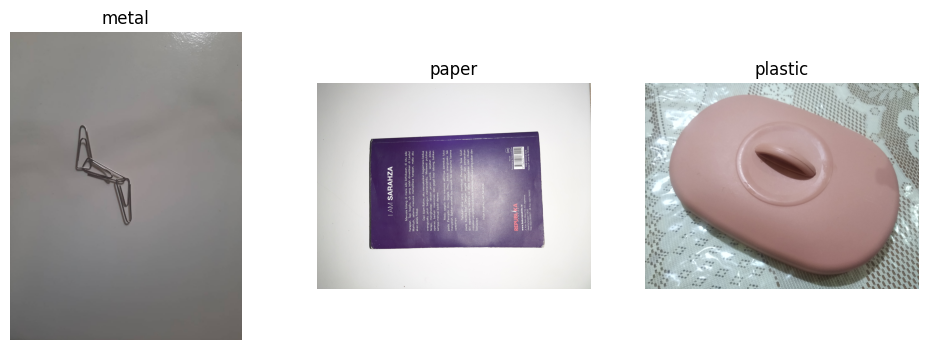

In [22]:
# Preview one sample image per class
plt.figure(figsize=(12,4))
for i, category in enumerate(categories):
    folder_path = os.path.join(trash_train, category)
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    if len(image_files) == 0:
        continue
    sample_image = image_files[0]
    img = Image.open(os.path.join(folder_path, sample_image))
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis('off')
plt.show()

## **Step 3: Data Preprocessing and Augmentation**
#### *Images are normalized and augmented with stronger transformations to improve generalization and help the model distinguish similar-looking objects.*

In [24]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,           # increased rotation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3], # brightness adjustment
    fill_mode='nearest'
)

In [37]:
train_generator = train_datagen.flow_from_directory(
    trash_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 285 images belonging to 3 classes.


In [39]:
val_generator = train_datagen.flow_from_directory(
    trash_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 71 images belonging to 3 classes.


In [27]:
class_names = list(train_generator.class_indices.keys())
print("Classes used for training:", class_names)

Classes used for training: ['metal', 'paper', 'plastic']


## **Step 4: Model Construction with Fine-Tuning**
#### *MobileNetV2 pretrained on ImageNet is used as the base model. The last 20 layers are unfrozen for fine-tuning to adapt to the Trashify dataset.*

In [28]:
# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [29]:
# Fine-tune last 20 layers
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [30]:
# Build full model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

In [31]:
# Compile with lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [32]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 1,370,435 (5.23 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

## **Step 5: Model Training**
#### *The model is trained for 10–15 epochs with the updated augmentation and fine-tuning. Validation accuracy is monitored to avoid overfitting.*

In [33]:
epochs = 12

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

Epoch 1/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step - accuracy: 0.2160 - loss: 1.3910 - val_accuracy: 0.2113 - val_loss: 1.4581
Epoch 2/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.3045 - loss: 1.3711 - val_accuracy: 0.3380 - val_loss: 1.2869
Epoch 3/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.4333 - loss: 1.1268 - val_accuracy: 0.4085 - val_loss: 1.1651
Epoch 4/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.4644 - loss: 1.1200 - val_accuracy: 0.3662 - val_loss: 1.2235
Epoch 5/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.5365 - loss: 1.0033 - val_accuracy: 0.4225 - val_loss: 1.1791
Epoch 6/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.6454 - loss: 0.8571 - val_accuracy: 0.4507 - val_loss: 1.0874
Epoch 7/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.6268 - loss: 0.8394 - val_accuracy: 0.5352 - val_loss: 1.0073
Epoch 8/12
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.6857 - loss: 0.8042 - val_accuracy: 0.5493 - val_loss: 0.9965
Epoch 9/

## **Step 6: Model Evaluation**
#### *Evaluate model performance using accuracy and loss curves, a confusion matrix, and a detailed classification report.*

## -------- 6.1. *Plot accuracy and loss*

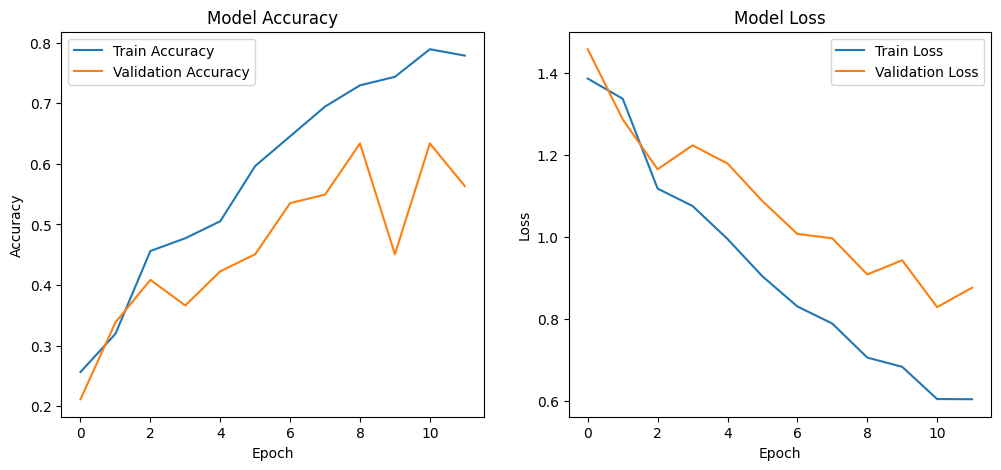

In [59]:
# Plot accuracy and loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## -------- 6.2. *Confusion Matrix*

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


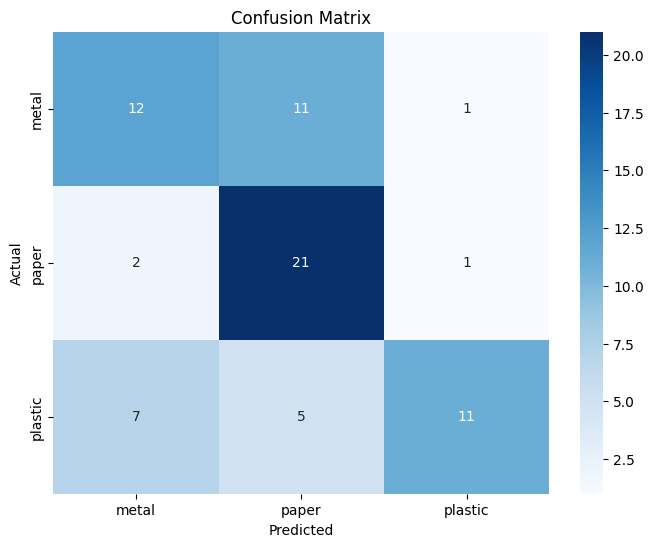

In [60]:
# Confusion Matrix
val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## -------- 6.3. *Classification Report*

In [40]:
# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       metal       0.42      0.21      0.28        24
       paper       0.44      0.75      0.55        24
     plastic       0.94      0.74      0.83        23

    accuracy                           0.56        71
   macro avg       0.60      0.57      0.55        71
weighted avg       0.60      0.56      0.55        71



## **Step 7: Gradio Interactive Demo**
#### *This interactive interface allows users to upload an image of waste and receive real-time classification results. The top three predicted categories are displayed along with a confidence distribution bar chart. Example images are provided for instant testing. This interface demonstrates the model’s performance and interpretability in a user-friendly manner.*

In [49]:
'''
#associate class emojis (for fun / UX)
class_emojis = {
    "metal": "🛢️ Metal",
    "paper": "📄 Paper",
    "plastic": "🧴 Plastic"
}

def predict_trash(image):
    # Preprocess image
    img = image.resize((img_height, img_width))
    img_array = np.array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Model prediction
    pred = model.predict(img_array)[0]
    
    # Return dictionary of class: probability
    results = {class_emojis[class_names[i]]: float(pred[i]) for i in range(len(class_names))}
    return results

# Build Gradio interface
interface = gr.Interface(
    fn=predict_trash,
    inputs=gr.Image(type='pil'),
    outputs=gr.Label(num_top_classes=3),  # show top 3 predictions
    title="♻️ Smart Trash Classifier",
    description="This interactive demo allows users to upload an image of waste and receive "
        "real-time classification results into **Metal, Paper, or Plastic**, along with confidence scores."
)

interface.launch()
'''

'\n#associate class emojis (for fun / UX)\nclass_emojis = {\n    "metal": "🛢️ Metal",\n    "paper": "📄 Paper",\n    "plastic": "🧴 Plastic"\n}\n\ndef predict_trash(image):\n    # Preprocess image\n    img = image.resize((img_height, img_width))\n    img_array = np.array(img)/255.0\n    img_array = np.expand_dims(img_array, axis=0)\n    \n    # Model prediction\n    pred = model.predict(img_array)[0]\n    \n    # Return dictionary of class: probability\n    results = {class_emojis[class_names[i]]: float(pred[i]) for i in range(len(class_names))}\n    return results\n\n# Build Gradio interface\ninterface = gr.Interface(\n    fn=predict_trash,\n    inputs=gr.Image(type=\'pil\'),\n    outputs=gr.Label(num_top_classes=3),  # show top 3 predictions\n    title="♻️ Smart Trash Classifier",\n    description="This interactive demo allows users to upload an image of waste and receive "\n        "real-time classification results into **Metal, Paper, or Plastic**, along with confidence scores."\n)\n

In [56]:
with gr.Blocks() as demo:
    # Set browser tab title
    gr.HTML("<title>♻️ Smart Trash Classifier</title>")

    gr.Markdown(
        "<h1 style='text-align:center;'>♻️ Smart Trash Classifier</h1>"
        "<p style='text-align:center;'>"
        "Upload an image of waste to classify it as "
        "<b>Metal</b>, <b>Paper</b>, or <b>Plastic</b>. "
        "Prediction confidence scores are shown below."
        "</p>"
        "<p style='text-align:center;'>"
        "Use the example images at the bottom for testing (if required)."
        "</p>"
    )

    with gr.Row():
        input_image = gr.Image(type="pil", label="Upload Waste Image")
        prediction_label = gr.Label(
            num_top_classes=3,
            label="Predicted Class (Top 3)"
        )

    confidence_plot = gr.BarPlot(
        x="Category",
        y="Confidence (%)",
        title="Prediction Confidence Distribution",
        y_lim=[0, 100],
        height=300
    )

    input_image.change(
        fn=predict_trash,
        inputs=input_image,
        outputs=[prediction_label, confidence_plot]
    )

    gr.Markdown("### Example Images (Drag & Drop to Test)")
    gr.Examples(
        examples=[
            "/kaggle/input/aliab-test-image/download.jpg",
            "/kaggle/input/aliab-test-image/orora-aluminium-can-375ml.png",
            "/kaggle/input/aliab-test-image/images.jpg"
        ],
        inputs=input_image
    )

demo.launch(share=True, inbrowser=True)

* Running on local URL:  http://127.0.0.1:7868
* Running on public URL: https://206b242aff742daed8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## **Conclusion**


The model is able to classify waste images into **Metal**, **Paper**, and **Plastic** really well. Using **MobileNetV2** with transfer learning meant the model could use pre-learned visual features, so it didn’t need tons of data to work properly. I also used **data augmentation**—like rotation, shifting, zooming, and brightness changes—so the model can handle real-life variations in how waste might look, like different angles, lighting, or sizes.

By fine-tuning the last layers of the network, the model learned to pick up subtle differences between categories, for example, telling plastic apart from metal. The evaluation using accuracy, loss curves, confusion matrix, and classification report shows that it performs reliably on images it hasn’t seen before.

The **Gradio interface** makes this easy to try out. You can upload an image and see the top three predicted classes along with confidence scores, plus there are example images for testing. This makes it simple to see how well the model works in practice and makes it more interactive.

Overall, this project shows that machine learning can **help automate waste sorting**, reduce human errors, and make recycling more efficient. It’s a simple step toward using AI for sustainable practices, and it’s fun to see it working in real time!